This notebook is to try out different architectures of NNs

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%run 'Functions.ipynb'
from keras.callbacks import EarlyStopping, LearningRateScheduler

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# 1. Training NN for a single chunk

In [587]:
min_max_scaler = MinMaxScaler()
n_iter = 500

chunk = 'S3'

data, labels, unique_mutations, aa_seq[chunk] = read_data(chunk)
labels /= 10.
scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()
init = initializers.Orthogonal(gain=1.0, seed=None)

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='random_uniform'))
model.add(Dense(100, activation='sigmoid', kernel_initializer='random_uniform'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

earlyStop = EarlyStopping(patience=100)

hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, verbose=1,
                        callbacks=[earlyStop])

proba = model.predict_proba(data, batch_size=500, verbose=0)

weights[chunk] = model.layers[0].get_weights()[0]
biases[chunk] = model.layers[0].get_weights()[1]

true[chunk] = labels
predicted[chunk] = min_max_scaler.inverse_transform(proba)
predicted[chunk] = predicted[chunk].flatten()
fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

Train on 47716 samples, validate on 482 samples
Epoch 1/500
47716/47716 [==============================] - 2s - loss: 0.0388 - val_loss: 0.0315
Epoch 2/500
47716/47716 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0262
Epoch 3/500
47716/47716 [==============================] - 0s - loss: 0.0238 - val_loss: 0.0204
Epoch 4/500
47716/47716 [==============================] - 0s - loss: 0.0227 - val_loss: 0.0230
Epoch 5/500
47716/47716 [==============================] - 0s - loss: 0.0218 - val_loss: 0.0227
Epoch 6/500
47716/47716 [==============================] - 0s - loss: 0.0210 - val_loss: 0.0176
Epoch 7/500
47716/47716 [==============================] - 0s - loss: 0.0199 - val_loss: 0.0164
Epoch 8/500
47716/47716 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0152
Epoch 9/500
47716/47716 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0153
Epoch 10/500
47716/47716 [==============================] - 0s - loss: 0.0177 - val_loss

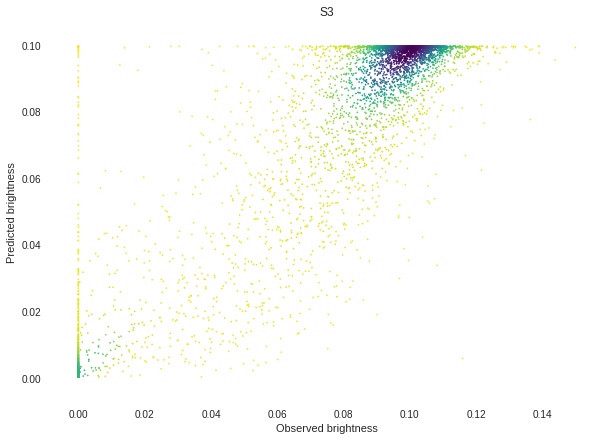

In [588]:
plt.figure(figsize = [10,7])
density_plot(true[chunk][:5000], predicted[chunk][:5000], chunk)

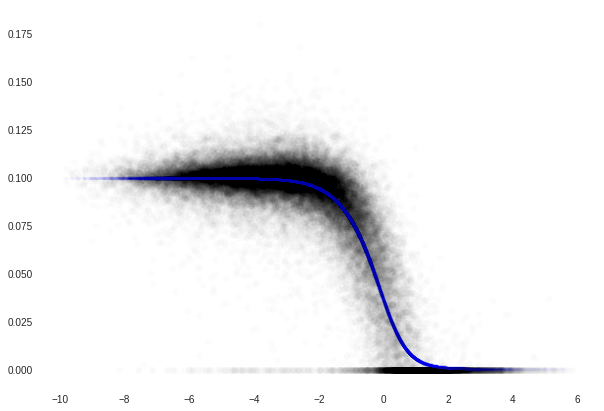

In [589]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[chunk], true[chunk], 'ok', alpha = 0.01)
plt.plot(fitness_potential[chunk], predicted[chunk], '.b', alpha = 0.01);

In [590]:
slope, intercept, r_value, p_value, std_err = stats.linregress(true[chunk],predicted[chunk])
r_value

0.89646000183584607

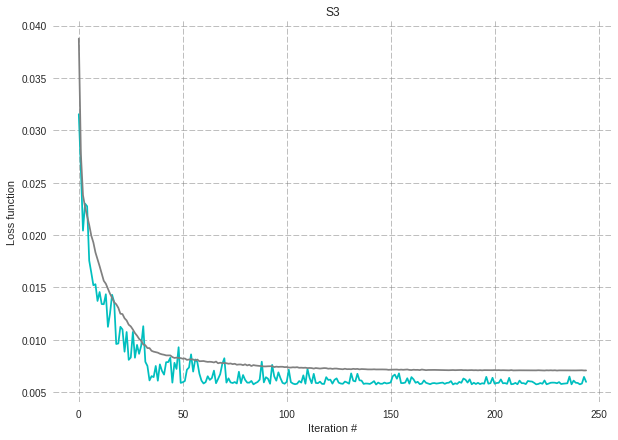

In [591]:
plt.figure(figsize=[10,7])
plt.title(chunk)
plt.plot([x for x in range(len(hist[chunk].history['loss']))], hist[chunk].history['val_loss'], 'c')
plt.plot([x for x in range(len(hist[chunk].history['loss']))], hist[chunk].history['loss'], 'gray')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Iteration #')
plt.ylabel('Loss function');

***

# 2. Training all the segments with the chosen architecture

#### 2.1. Training

In [3]:
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
biases = {}
aa_seq = {}

In [ ]:
min_max_scaler = MinMaxScaler([0.2,0.8])
n_iter = 500

for chunk in chunks:
    print (chunk)
    data, labels, unique_mutations, aa_seq[chunk] = read_data(chunk)
    
    scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))
    
    x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)
    
    model = Sequential()

    model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='random_uniform'))
    model.add(Dense(100, activation='sigmoid', kernel_initializer='random_uniform'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)
    
    lr = np.linspace(0.1, 0.001, n_iter)
    lrAdj = LearningRateScheduler(lambda iter: float(lr[iter]))
    earlyStop = EarlyStopping(patience=100)
    
    hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                            epochs=n_iter, batch_size=500, shuffle=True, verbose=0,
                            callbacks=[earlyStop])
    
    proba = model.predict_proba(data, batch_size=500, verbose=0)
    
    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]
    
    true[chunk] = scaledLabels
    predicted[chunk] = proba
    predicted[chunk] = predicted[chunk].flatten()
    fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10


***

#### Non-scaled

In [14]:
max(labels)

1.5731477344999998

In [15]:
max(predicted[chunk])

0.99448001

#### Scaled

In [16]:
max(scaledLabels.flatten())

0.80000000000000004

In [17]:
max(proba.flatten())

0.57929558

***

In [452]:
for chunk in chunks:

    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    if R>0:
        fitness_potential[chunk]*=-1
        
    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    print chunk, '\t', R

S1 	-0.781003309154
S2 	-0.828060081671
S3 	-0.814613164258
S4 	-0.847831471167
S5 	-0.584533194282
S6 	-0.818332819161
S7 	-0.873755263962
S8 	-0.816056738635
S9 	-0.943398045418
S10 	-0.983284688329
S11 	-0.901391804727
S12 	-0.681914631122


#### 2.2. Plotting

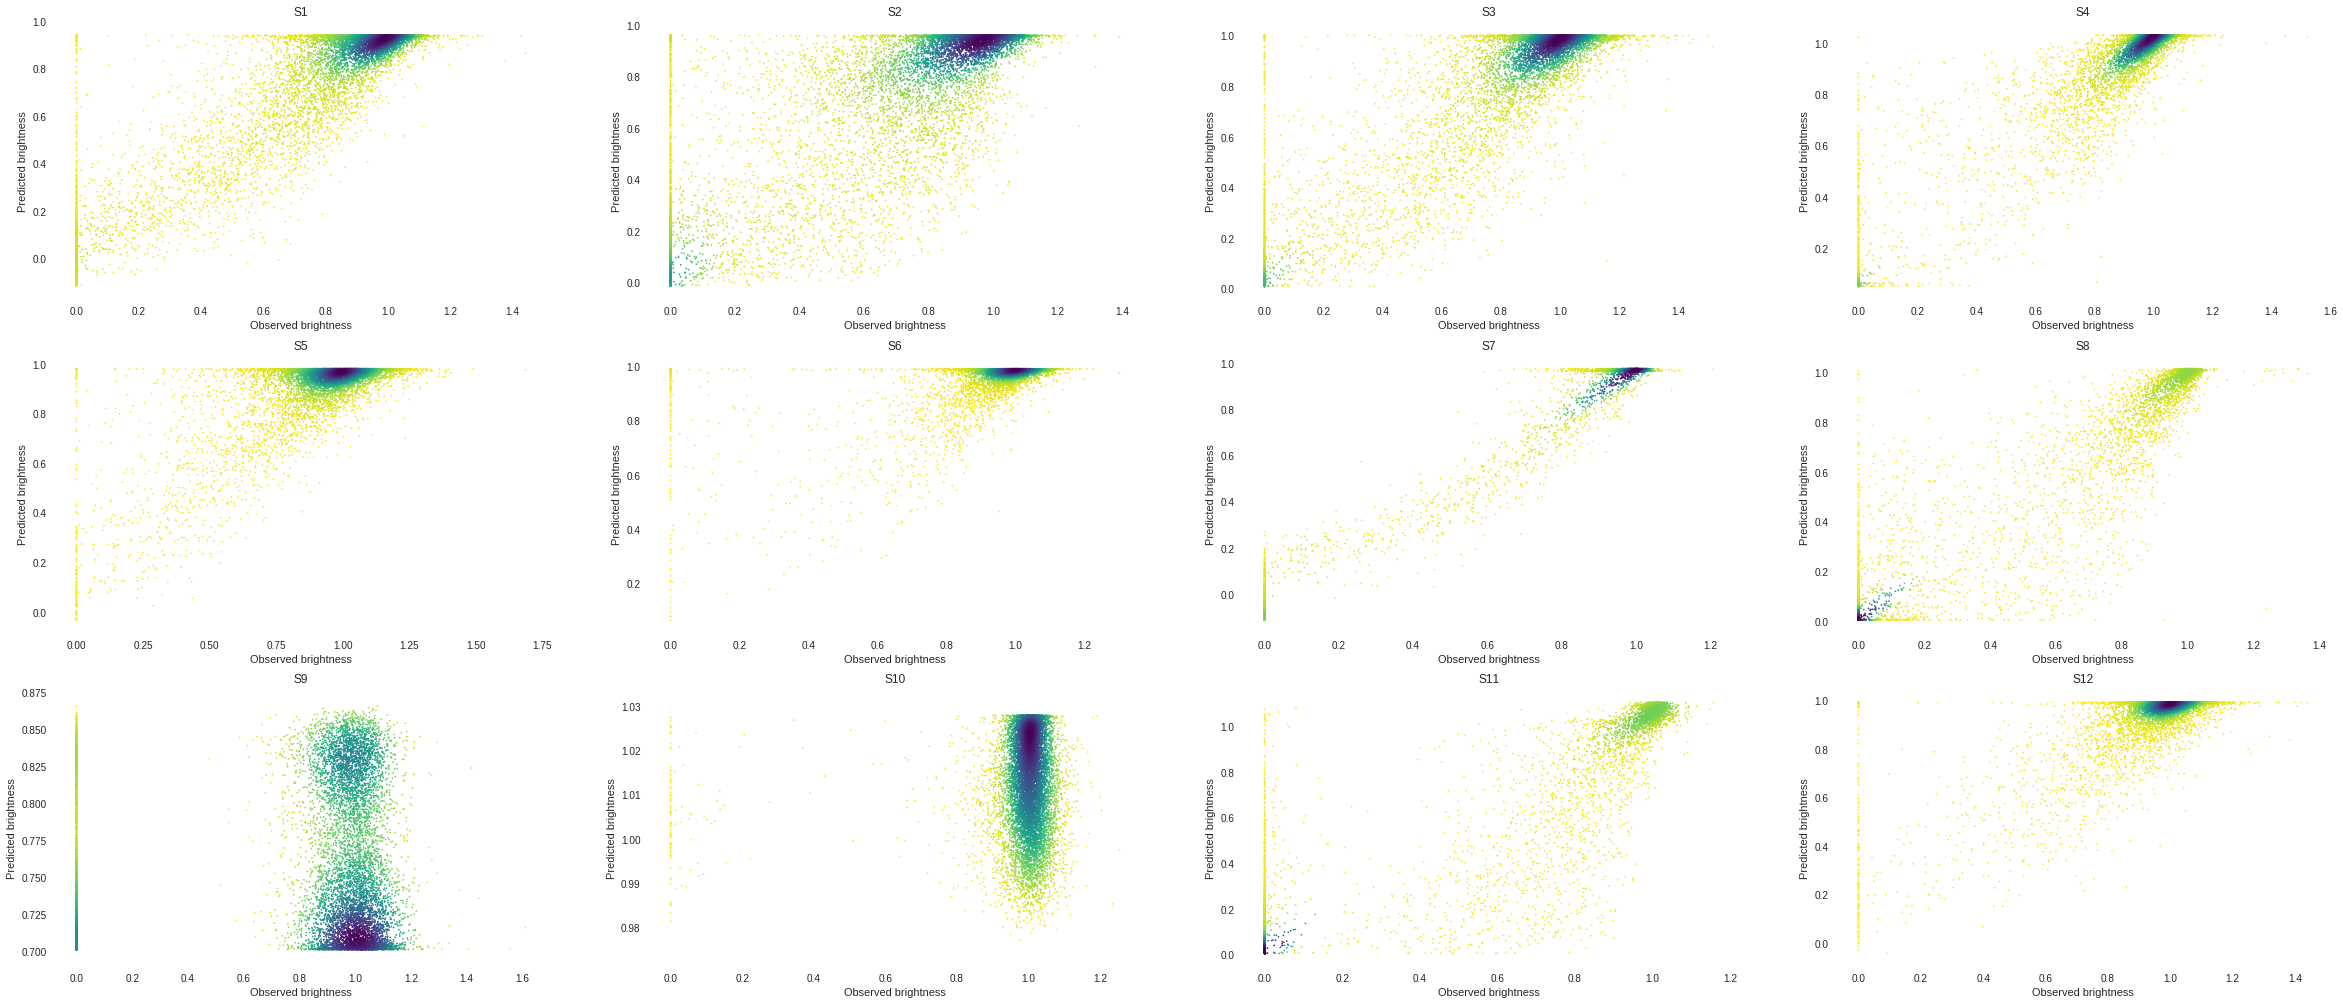

In [5]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
#     plt.ylim(0,1)
#     plt.xlim(0,1)
    density_plot(true[chunk][:10000], predicted[chunk][:10000], chunk)
    count+=1

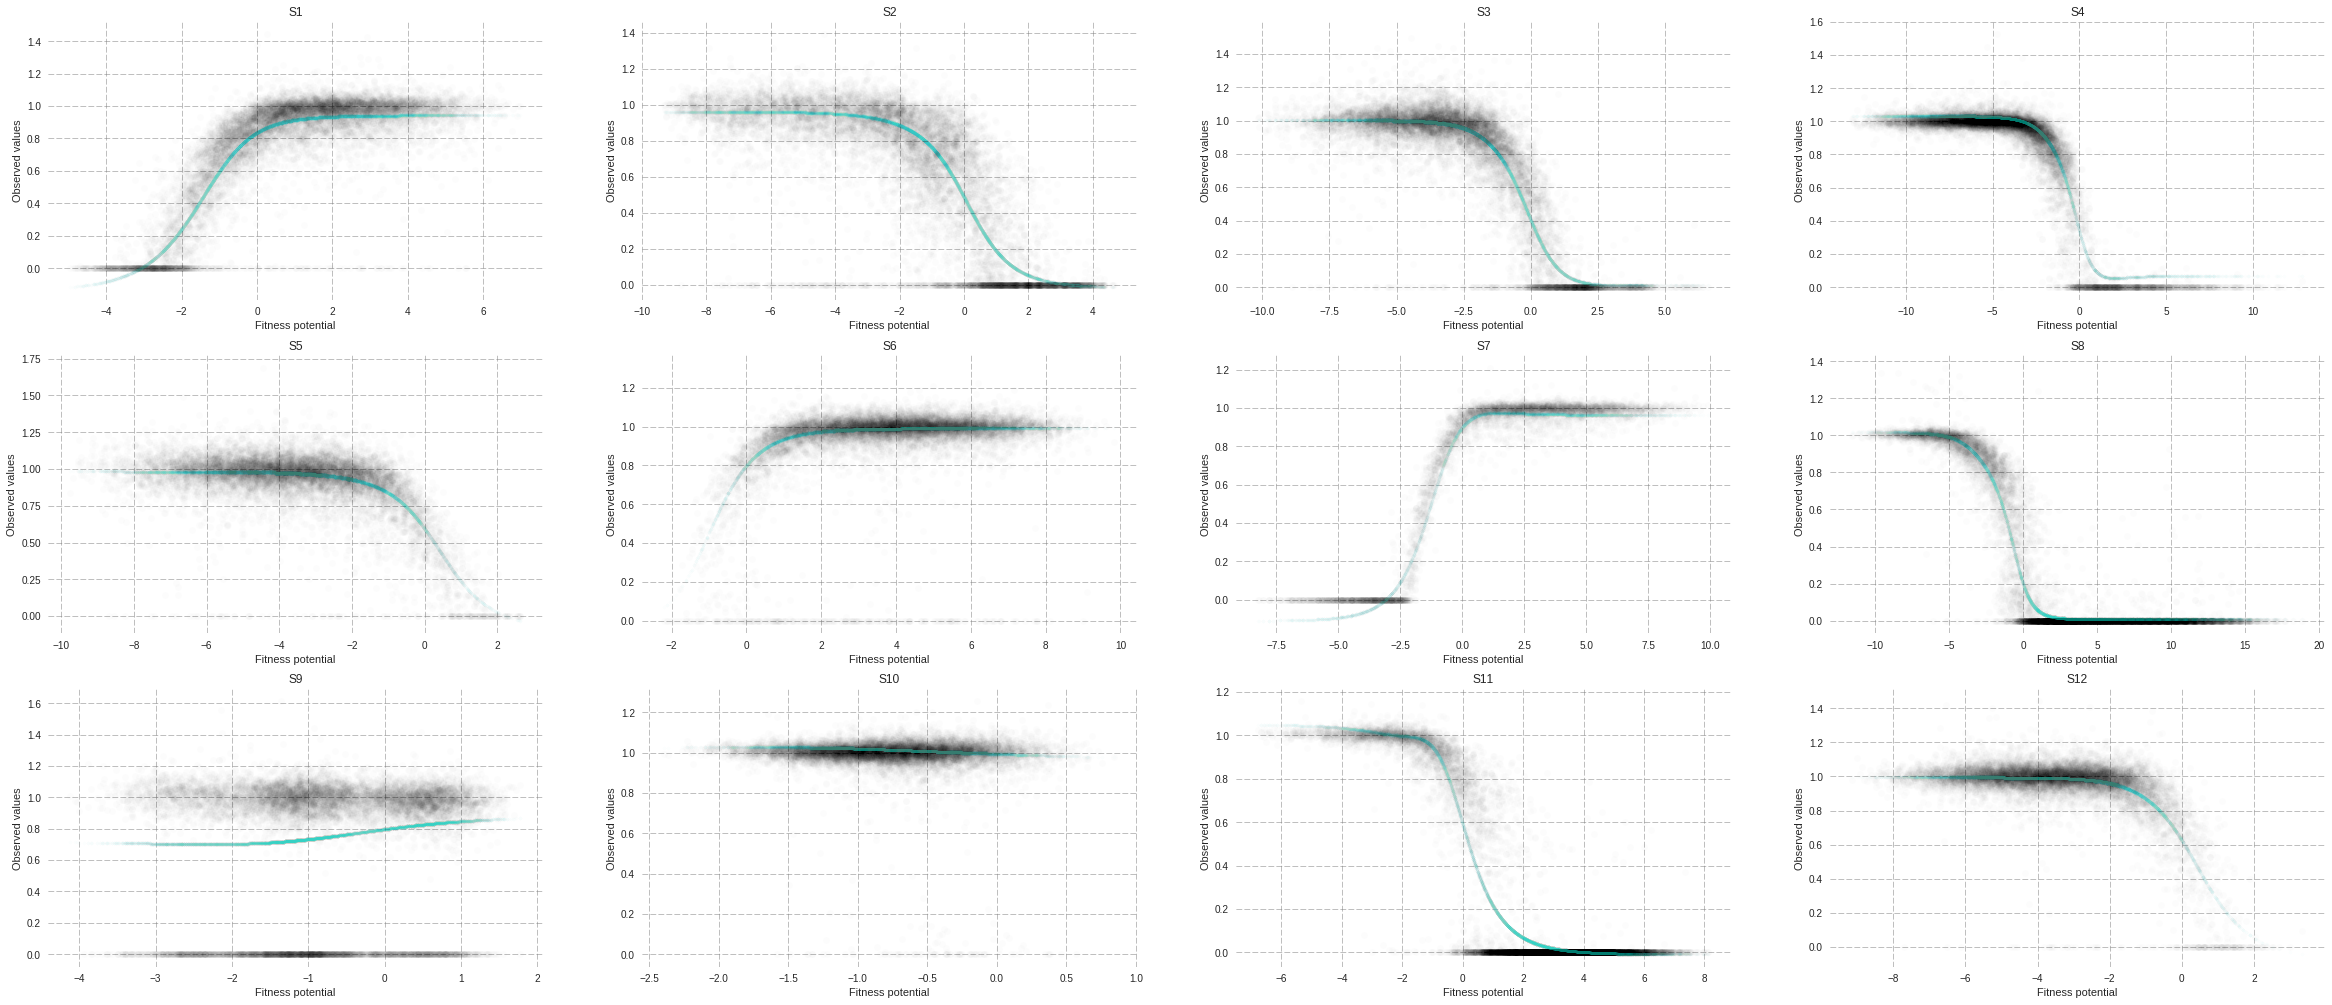

In [19]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.plot(X, Y, 'ok', alpha = 0.01)
    plt.plot(X, predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.01)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Fitness potential')
    plt.ylabel('Observed values')
    count+=1

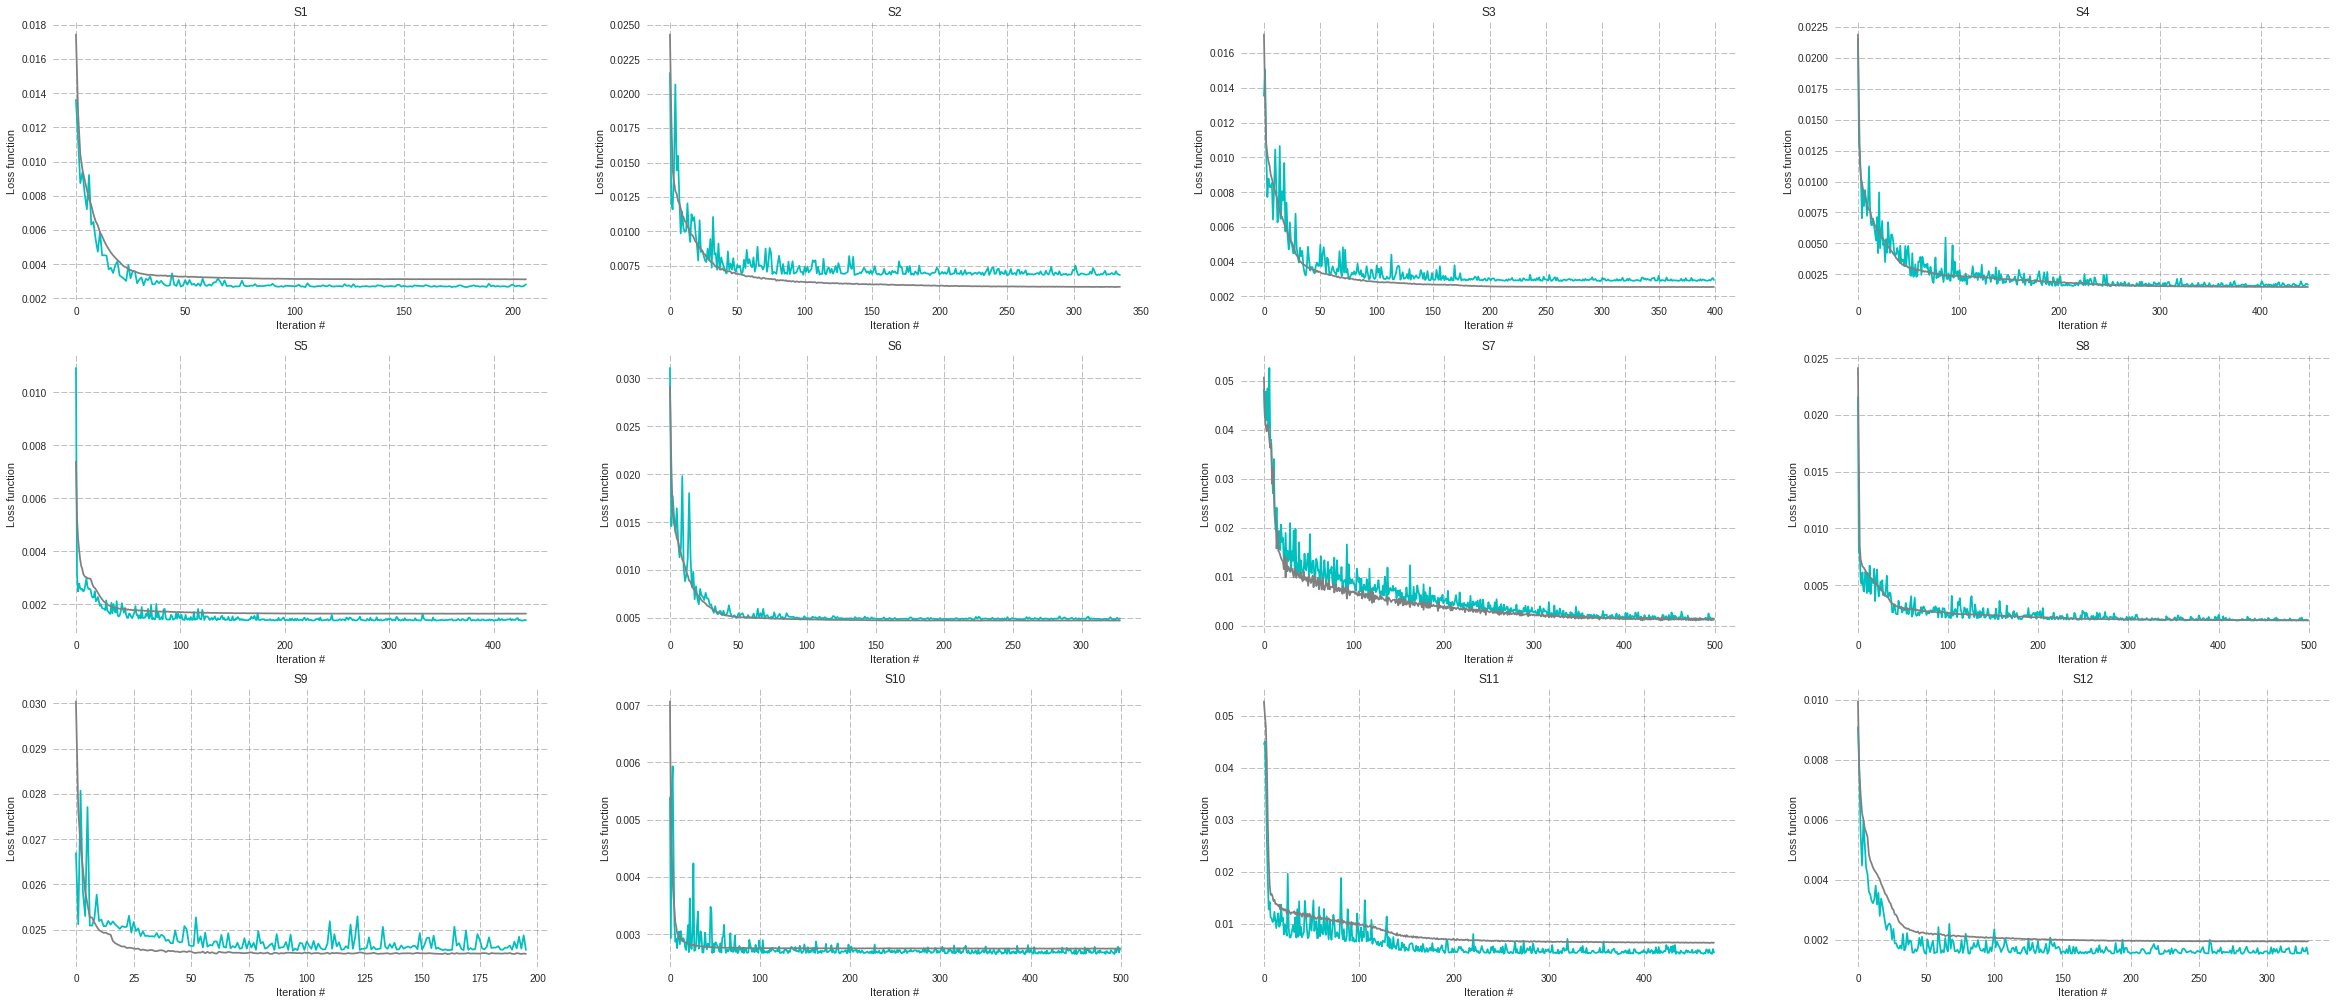

In [10]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['val_loss'], 'c')
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['loss'], 'gray')
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    count+=1

#### 2.3. Extracting residuals

In [270]:
residualsDF = {}

for chunk in chunks:
    residualsDF[chunk] = pd.DataFrame(predicted[chunk] - true[chunk], index = aa_seq[chunk])
    residualsDF[chunk]['fitnessPotential'] = fitness_potential[chunk]
    residualsDF[chunk]['observed'] = true[chunk]
    residualsDF[chunk].columns = ['predictedMinusObserved', 'fitnessPotential', 'observed']
    residualsDF[chunk].to_csv('../residuals/' + chunk + '.csv', sep=',')

#### 2.4. Extracting weights

In [20]:
weightsDF = {}

for chunk in chunks:
    weightsDF[chunk] = pd.DataFrame(weights[chunk], index = unique_mutations[chunk])

TypeError: list indices must be integers, not str

In [21]:
unique_mutations

['0H',
 '0K',
 '0Q',
 '12E',
 '12K',
 '12R',
 '13A',
 '13D',
 '14H',
 '15I',
 '15V',
 '16E',
 '16P',
 '16Q',
 '3H',
 '3N',
 '3Q',
 '5C',
 '5F',
 '5S']

# 3. Checking correlations and loss function

### 3.1. Correlations prediction vs observed + Lucas's values

In [11]:
mse = []

for chunk in chunks:
    mse.append(hist[chunk].history['loss'][-1])

In [12]:
r_values = []

for chunk in chunks:
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_pred)
    r_values.append(r_value)
    
lucas = [0.76386, 0.62877, 0.80256, 0.91289, 0.49342, 0.15075, 0.97532, 0.88078, 0.01069, 0.0096183, 0.81741, 0.54172]

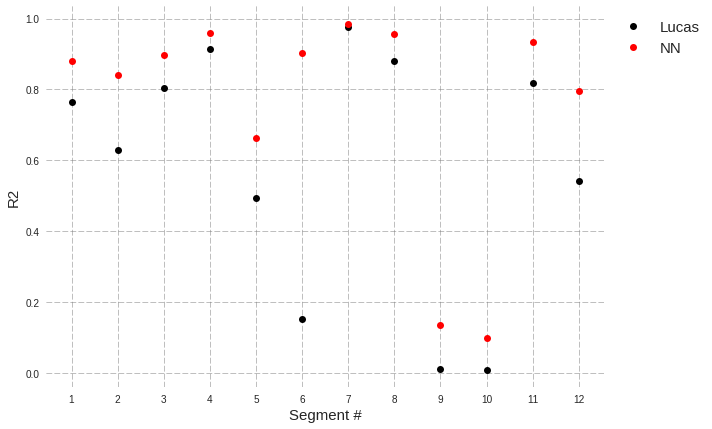

In [13]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], lucas, 'ok', label='Lucas')
plt.plot([x for x in range(1, 13)], r_values, 'or', label='NN')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.ylabel('R2', fontsize=15)
plt.xticks([x for x in range(1,13)]);

### 3.2. Mean Squared Error

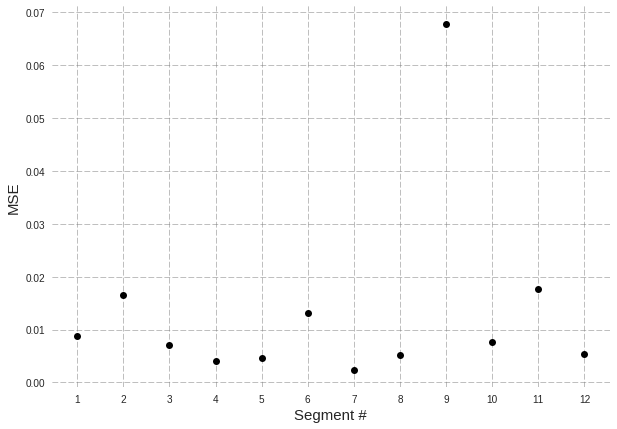

In [276]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], mse, 'ok')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks([x for x in range(1,13)]);

# 4. Crossvalidation

### 4.1. Comparing train and test sets accuracy predictions

In [ ]:
test_r2 = {}
train_r2 = {}

for chunk in chunks:
    print (chunk)
    data, labels = read_data(chunk)
    
    cv = cross_validation.StratifiedKFold(labels, n_folds = 10, shuffle = True)

    test_r2[chunk] = []
    train_r2[chunk] = []

    for train_idx, test_idx in cv:
        X_train, y_train = data[train_idx,:], labels[train_idx]
        X_test, y_test = data[test_idx,:],labels[test_idx]

        model = Sequential()
        init = initializers.Orthogonal(gain=1.0, seed=None)

        model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
        model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
        model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

        model.compile(optimizer=opt,
                      loss='mean_squared_error',
                      verbose=0)

        model.fit(X_train, y_train, epochs=100, batch_size=500, shuffle=True, verbose=0)
        proba_train = model.predict_proba(X_train, batch_size=500, verbose=0)
        proba_test = model.predict_proba(X_test, batch_size=500, verbose=0)

        predicted_train = proba_train.flatten()
        predicted_test = proba_test.flatten()

        _, _, Rtrain, _, _ = stats.linregress(y_train, predicted_train)
        _, _, Rtest, _, _ = stats.linregress(y_test, predicted_test)

        test_r2[chunk].append(Rtest)
        train_r2[chunk].append(Rtrain)

S1


In [180]:
train_r2['S5']

[0.60423015365282018,
 0.0,
 -0.00039742165628629421,
 0.6018810801083414,
 0.60497792503494985,
 -0.0018418963715206196,
 0.60649436280492008,
 0.60024094578788734,
 -0.00057688693933001848,
 0.60018624848174496]

KeyError: 'S1'

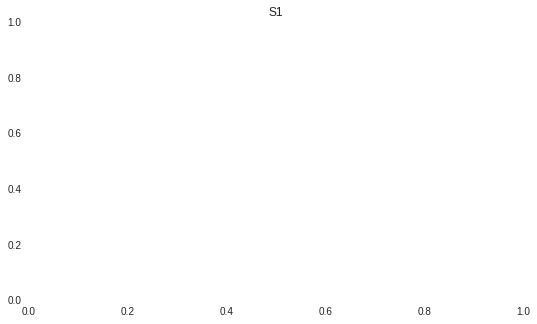

In [179]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.boxplot([train_r2[chunk], test_r2[chunk]], labels=['Train set', 'Test set'])
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.ylabel('R2')
    plt.ylim(0,1)
    count+=1

### 4.2. Checking accuracy dependence from the test set size

In [171]:
from sklearn.model_selection import train_test_split
nfold=10
data, labels = read_data(chunk)

for size in [0.1, 0.05, 0.01, 0.001, 0]:
    print (size)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=size)

    cv = cross_validation.KFold(labels.shape[0], n_folds = nfold, shuffle = True)

    model = Sequential()
    init = initializers.Orthogonal(gain=1.0, seed=None)

    model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
    model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)

    model.fit(X_train, y_train, epochs=500, batch_size=500, shuffle=True, verbose=0)
    proba_train = model.predict_proba(X_train, batch_size=500, verbose=0)

    predicted_train = proba_train.flatten()
    _, _, Rtrain, _, _ = stats.linregress(y_train, predicted_train)

    if size != 0:
        proba_test = model.predict_proba(X_test, batch_size=500, verbose=0)
        predicted_test = proba_test.flatten()
        _, _, Rtest, _, _ = stats.linregress(y_test, predicted_test)
        print (Rtest)
        
    print (Rtrain)

0.05


KeyboardInterrupt: 

In [ ]:
x = [0.1, 0.05, 0.01, 0.001, 0]
test = Rtest
train = Rtrain

plt.figure(figsize=[10,3])
plt.plot(x, train, 'ok', alpha = 0.7, markersize=5, label='train')
plt.plot(x[:-1], test, 'om', alpha = 0.7, markersize=5, label='test')
plt.grid(True, ls='--', lw=0.5, dash_capstyle='round', c='gray')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.ylim(0,1)
plt.xlim(-0.005,0.105)
plt.xticks([i for i in np.arange(0,0.11,0.01)])
plt.xlabel('Test set fraction', fontsize=10)
plt.ylabel('R2', fontsize=10)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='left')
x = [-1, 1]
plt.plot(x, [0.9 for i in x], ':k', lw=0.7);